In [ ]:
!pip install -U scikit-learn
!pip install -U sexmachine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 336 kB 4.3 MB/s 
  Created wheel for sexmachine: filename=SexMachine-0.1.1-py3-none-any.whl size=379460 sha256=3ddd5b1efd4b15c4b52bc2768a441112a51106d654584cdfde86fad108aef58f
  Stored in directory: /root/.cache/pip/wheels/dd/0e/e8/1835afdbc052699e48971e735d40625bdd9ee2c335eb98af3a
Successfully built sexmachine


In [ ]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve  
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# %matplotlib inline 

from sklearn.model_selection import cross_val_score

In [ ]:
import sexmachine.detector as gender


In [ ]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("users.csv")
    fake_users = pd.read_csv("fusers.csv")
    print(genuine_users.columns)
    print(genuine_users.describe())
    print(fake_users.describe())
    x=pd.concat([genuine_users,fake_users])   
    y=len(genuine_users)*[1] + len(fake_users)*[0]
    return x,y

In [ ]:
def predict_sex(name):
    sex_predictor = gender.Detector(unknown_value=u"unknown",case_sensitive=False)
    first_name= name.str.split(' ').str.get(0)
    sex= first_name.apply(sex_predictor.get_gender)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex.map(sex_dict).astype(int)
    return sex_code

In [ ]:
def extract_features(x):
    #lang_list = list(enumerate(np.unique(x['lang'])))   
    #lang_dict = { name : i for i, name in lang_list }             
    #x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)
    #x.loc[:,'sex_code']=predict_sex(x['name'])
    #feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang']
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','lang']
    x=x.loc[:,feature_columns_to_use]
    y=pd.get_dummies(x.lang)
    del x["lang"]
    x = pd.concat([y,x], axis=1)
    return x


In [ ]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:

def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    
    print("False Positive rate: ",false_positive_rate)
    print("True Positive rate: ",true_positive_rate)

    
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
def train(X_train,y_train,X_test):
    """ Trains and predicts dataset with a SVM classifier """
    # Scaling features
    X_train=preprocessing.scale(X_train)
    X_test=preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    cvk = StratifiedKFold(n_splits=2)
    classifier = SVC()
    clf = GridSearchCV(classifier,param_grid=param,cv=cvk)
    clf.fit(X_train,y_train)
    print("The best classifier is: ",clf.best_estimator_)
    clf.best_estimator_.fit(X_train,y_train)
    # Estimate score
    scores = cross_val_score(clf.best_estimator_, X_train,y_train, cv=5)
    print(scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' %clf.best_estimator_.gamma
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test,y_pred


In [ ]:

print("reading datasets.....\n")
x,y=read_datasets()
print(x.shape)


reading datasets.....

Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'created_at',
       'url', 'lang', 'time_zone', 'location', 'default_profile',
       'default_profile_image', 'geo_enabled', 'profile_image_url',
       'profile_banner_url', 'profile_use_background_image',
       'profile_background_image_url_https', 'profile_text_color',
       'profile_image_url_https', 'profile_sidebar_border_color',
       'profile_background_tile', 'profile_sidebar_fill_color',
       'profile_background_image_url', 'profile_background_color',
       'profile_link_color', 'utc_offset', 'protected', 'verified',
       'description', 'updated', 'dataset'],
      dtype='object')
                 id  statuses_count  followers_count  friends_count  \
count  1.481000e+03     1481.000000      1481.000000    1481.000000   
mean   4.000432e+08     3140.782579       690.922350     403.128292   
std    2.961304e+08    

In [ ]:
print("extracting featues.....\n")
x=extract_features(x)
print(x.columns)
print(x.describe())

extracting featues.....

Index(['de', 'en', 'es', 'fr', 'gl', 'it', 'nl', 'tr', 'statuses_count',
       'followers_count', 'friends_count', 'favourites_count', 'listed_count'],
      dtype='object')
                de           en           es           fr           gl  \
count  2818.000000  2818.000000  2818.000000  2818.000000  2818.000000   
mean      0.000710     0.533002     0.003903     0.001065     0.000355   
std       0.026636     0.498998     0.062367     0.032616     0.018838   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     1.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                it           nl           tr  statuses_count  followers_count  \
count  2818.000000  2818.000000  2818.000000     281

In [ ]:
print("spliting datasets in train and test dataset...\n")
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)
z = y_test

spliting datasets in train and test dataset...



# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10, random_state=0)
classifier.fit(X_train, y_train)
Y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test,Y_pred))
print("Accuracy for Random Forest Classifier: " +str(accuracy_score(y_test, Y_pred)))
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

[[266   1]
 [  1 296]]
Accuracy for Random Forest Classifier: 0.9964539007092199
              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99       267
     Genuine       1.00      0.99      0.99       297

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564



# Support Vector Classifier

training datasets.......

The best classifier is:  SVC(C=316.22776601683796, gamma=1.0)
[0.99778271 0.99778271 0.99556541 0.99778271 0.99777778]
Estimated score: 0.99734 (+/- 0.00044)


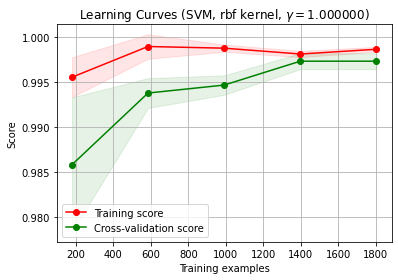

True


In [ ]:
print("training datasets.......\n")
y_test,y_pred = train(X_train,y_train,X_test)
print(y_test==z)

In [ ]:
print('Classification Accuracy on Test dataset: ' ,accuracy_score(y_test, y_pred))

Classification Accuracy on Test dataset:  0.9911347517730497


Confusion matrix, without normalization
[[266   1]
 [  4 293]]


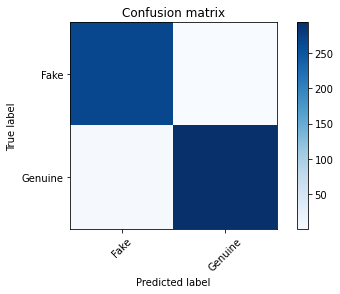

In [ ]:
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99       267
     Genuine       1.00      0.99      0.99       297

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564



False Positive rate:  [0.         0.00374532 1.        ]
True Positive rate:  [0.         0.98653199 1.        ]


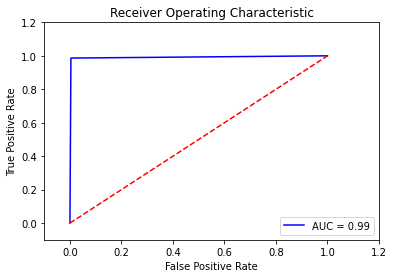

In [ ]:
plot_roc_curve(y_test, y_pred)

In [ ]:
y_test = np.array(y_test)
check = np.concatenate([(y_test).reshape(len(y_test),1), y_pred.reshape(len(y_pred), 1)],1)
print(check[1:20,:])
print(x)
print(y)

[[1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]]
      de  en  es  ...  friends_count  favourites_count  listed_count
0      0   0   0  ...           2385               145            52
1      0   1   0  ...            381                 9            40
2      0   1   0  ...             87               323            16
3      0   1   0  ...            622              1118            32
4      0   0   0  ...             64                13             0
...   ..  ..  ..  ...            ...               ...           ...
1332   0   1   0  ...             17                 0             0
1333   0   1   0  ...             17                 0             0
1334   0   1   0  ...             15                 0             0
1335   0   1   0  ...             16                 0             0
1336   0   1   0  ...             17                 0             0

[2818 rows x 13 columns]
[1, 1, 1, 1,